# Assignment 3: Exploration in Reinforcement Learning
## Question 3: Bernoulli Bandits
---
### Author: Clément Bonnet
---

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from tqdm import tqdm

SAVE_PLOTS_FOR_PDF = False

In [2]:
if SAVE_PLOTS_FOR_PDF:
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

---

In [3]:
class BernouilliBandit:
    def __init__(self, means=None, k=None):
        if k is not None and means is None:
            self.means = np.random.rand(k)
        elif k is None and means is not None:
            self.means = means
        else:
            raise ValueError("Please give only one of these: means or k, but not both.")
        self.k = len(self.means)
        self.best_arm = np.max(self.means)
    
    def pull(self, i):
        if i >= self.k:
            raise ValueError(
                "Value {} is greater than the maximum possible: {}".format(i,self.k))
        return np.random.binomial(1, self.means[i])


class BanditAlgorithm:
    def __init__(self, bandit):
        self.bandit = bandit
        self._reset()
    
    def _reset(self):
        self.t = 0
        self.means_hat = np.zeros_like(self.bandit.means)
        self.N = np.zeros_like(self.bandit.means)
        self.rewards = []
        self.choices = []
        self.regret = []

    def _select_arm(self):
        raise NotImplementedError
    
    def step(self):
        i = self._select_arm()
        self.choices.append(i)
        x = self.bandit.pull(i)
        self.rewards.append(x)
        expected_regret = self.bandit.best_arm - self.bandit.means[i]
        self.regret.append(expected_regret)
        self.means_hat[i] = self.N[i]/(self.N[i] + 1) * self.means_hat[i] + x/(self.N[i] + 1)
        self.N[i] += 1
        self.t += 1

    def run(self, n):
        self._reset()
        for _ in range(n):
            self.step()


class UCB(BanditAlgorithm):
    def __init__(self, bandit):
        super().__init__(bandit)

    def _select_arm(self):
        i = np.argmax(self.means_hat + \
            np.sqrt(
                np.log(1 + self.t*np.log(np.log(self.t)))/\
                (2*self.N)))
        return i


class KLUCB(BanditAlgorithm):
    def __init__(self, bandit):
        super().__init__(bandit)
        self.k = bandit.k
        self._bisection_eps = 1e-1
    
    def _kl_divergence(self, mu_1, mu_2):
        if mu_1 == 0:
            return -np.log(1 - mu_2)
        elif mu_1 == 1:
            return -np.log(mu_2)
        elif mu_2 == 0 or mu_2 == 1:
            return np.inf            
        else:
            return mu_1*np.log(mu_1/mu_2) + (1 - mu_1)*np.log((1 - mu_1)/(1 - mu_2))

    def _bisection_f(self, mu, a):
        if self.t < 3:
            return - self._kl_divergence(self.means_hat[a], mu)
        else:
            return np.log(1 + (self.t)*np.log(np.log(self.t)))/self.N[a] - self._kl_divergence(self.means_hat[a], mu)


    def _bisection(self, a):
        mu_min, mu_max = self.means_hat[a], 1
        while mu_max - mu_min > self._bisection_eps:
            mu_mid = (mu_min + mu_max)/2
            if self._bisection_f(mu_mid, a) < 0:
                mu_max = mu_mid
            else:
                mu_min = mu_mid 
        return mu_min

    def _select_arm(self):
        if self.t < self.k:
            # select first each arm once
            i = self.t
        else:
            i = np.argmax(
                np.array([self._bisection(a) for a in range(self.k)])
            )
        return i


def plot_regret_delta(regrets_ucb, regrets_klucb, deltas, mu_1):
    if SAVE_PLOTS_FOR_PDF:
        if mu_1 == 0.5:
            plt.figure(figsize=(6,4));
        else:
            plt.figure(figsize=(3.2,4));
    plt.plot(deltas, regrets_ucb, label="UCB");
    plt.plot(deltas, regrets_klucb, label="KL-UCB");
    plt.xlabel("$\Delta$");
    plt.ylabel("Regret");
    if mu_1 == 0.5:
        plt.legend();
    if SAVE_PLOTS_FOR_PDF:
        plt.tight_layout();
        plt.savefig("regrets_{}.pgf".format(mu_1));
    else:
        plt.title("Regret for $\mu_1 = {}$ and $\mu_2 = 0.5 + \Delta$.".format(mu_1));
        plt.show();

def delta_regrets(n, delta_step, n_avg_delta, mu_1):
    n_deltas = 1 + int(1/delta_step)
    deltas = np.linspace(-0.5, 0.5, n_deltas)
    regrets_ucb = np.zeros(n_deltas)
    regrets_klucb = np.zeros(n_deltas)
    for i, delta in enumerate(tqdm(deltas)):
        means = np.array([mu_1, 0.5 + delta])
        bern_bandit = BernouilliBandit(means)
        klucb = KLUCB(bern_bandit)
        ucb = UCB(bern_bandit)
        for _ in range(n_avg_delta):
            ucb.run(n)
            klucb.run(n)
            regrets_ucb[i] += sum(ucb.regret)
            regrets_klucb[i] += sum(klucb.regret)
        regrets_ucb[i] /= n_avg_delta
        regrets_klucb[i] /= n_avg_delta
    return regrets_ucb, regrets_klucb, deltas

## Experiments

In [3]:
n = 10_000         # Number of interactions with the bandits
delta_step = 0.01  # Defines the step size between each delta [-0.5, -0.5 + delta_step, ..., 0.5]
n_avg_delta = 5    # Number of runs to average over, for each delta (50 was used for the assignment)

np.random.seed(0)
to_plot = []
for mu_1 in [0.1, 0.5, 0.9]:
    regrets_ucb, regrets_klucb, deltas = delta_regrets(n, delta_step, n_avg_delta, mu_1)
    to_plot.append((regrets_ucb, regrets_klucb, deltas, mu_1))

100%|██████████| 101/101 [1:01:19<00:00, 36.43s/it]


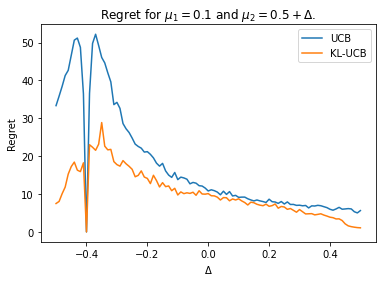

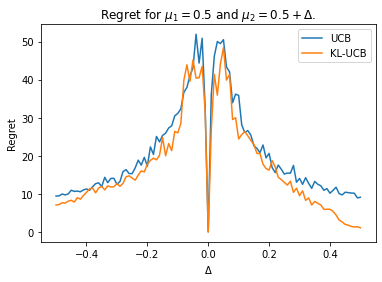

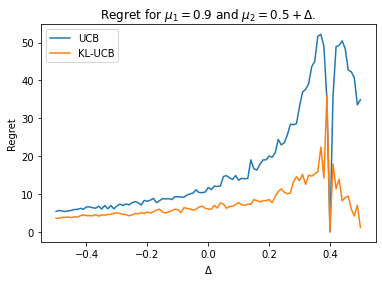

In [4]:
for regrets_ucb, regrets_klucb, deltas, mu_1 in to_plot:
    plot_regret_delta(regrets_ucb, regrets_klucb, deltas, mu_1)